# UCR Dataset: Plane

**Dataset Homepage:** https://timeseriesclassification.com/description.php?Dataset=Plane.

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Classification (Inception) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-omz7rumnllmla).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
# SageMaker algorithm ARN from AWS Marketplace
algo_arn = "arn:aws:sagemaker:<...>"

In [2]:
import io
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Data preparation

#### 2.1 Training dataset

Load the training data.

In [3]:
training_dataset = pd.DataFrame(data=np.genfromtxt("Plane_TRAIN.txt"))

In [4]:
training_dataset.shape

(105, 145)

In [5]:
training_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,1.0,2.483940,2.276286,2.067516,1.921893,1.718775,1.508428,1.300675,1.090286,0.882733,...,0.713395,0.915860,1.120450,1.326346,1.532210,1.739919,1.945732,2.153986,2.361228,2.483939
1,4.0,2.603320,2.340699,2.082285,1.825624,1.567706,1.312203,1.057195,0.801716,0.546683,...,0.427274,0.676066,0.921299,1.171722,1.418897,1.663607,1.915828,2.162467,2.405276,2.605294
2,6.0,2.757321,2.576667,2.363323,2.151578,1.940218,1.729427,1.519429,1.309547,1.100253,...,0.954268,1.157343,1.363317,1.566326,1.769860,1.973864,2.178290,2.380841,2.584945,2.759135
3,5.0,0.916063,0.720145,0.522445,0.325826,0.134381,-0.054012,-0.235525,-0.409605,-0.574453,...,1.133398,0.984352,0.760642,0.541502,0.517342,0.582836,0.658641,0.757901,0.853401,0.916217
4,2.0,2.656142,2.388145,2.118595,1.849677,1.576579,1.310169,1.109699,0.930998,0.750668,...,0.636663,0.792403,0.986072,1.178943,1.392679,1.660325,1.929237,2.199162,2.469993,2.655524


In [6]:
training_dataset.iloc[:, 0].sort_values().unique()

array([1., 2., 3., 4., 5., 6., 7.])

In [7]:
training_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

1.0    15
2.0    14
3.0     9
4.0    16
5.0    13
6.0    18
7.0    20
Name: count, dtype: int64

Visualize the training data.

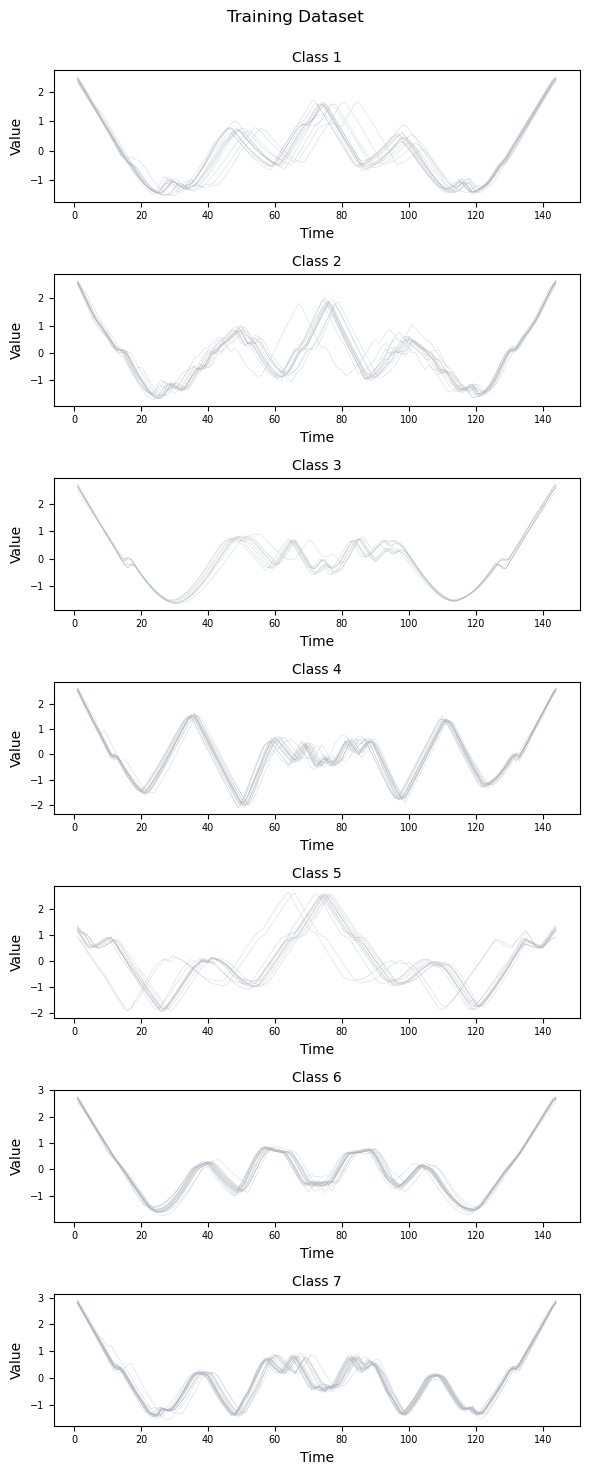

In [8]:
fig, axs = plt.subplots(nrows=training_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 15))
for i, c in enumerate(training_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(training_dataset[training_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.2)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Training Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.show()

Upload the training data to S3.

In [9]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="Plane_train.csv"
)

In [10]:
training_data

's3://sagemaker-eu-west-1-661670223746/Plane_train.csv'

#### 2.2 Test dataset

Load the test data.

In [11]:
test_dataset = pd.DataFrame(data=np.genfromtxt("Plane_TEST.txt"))

In [12]:
test_dataset.shape

(105, 145)

In [13]:
test_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,6.0,2.684302,2.453768,2.230384,2.011169,1.794118,1.577387,1.359680,1.144486,0.927136,...,1.015645,1.214339,1.420208,1.620083,1.820570,2.021606,2.217568,2.419725,2.613000,2.692358
1,1.0,2.472610,2.235611,2.013957,1.814244,1.586538,1.366994,1.150972,0.942407,0.726306,...,0.933347,1.135585,1.331997,1.528856,1.716464,1.913914,2.111944,2.300773,2.444754,2.488623
2,3.0,2.612109,2.410407,2.209536,2.009077,1.808427,1.607662,1.410399,1.208933,1.007504,...,0.864645,1.063090,1.256423,1.459508,1.660530,1.859156,2.057600,2.256929,2.455148,2.612516
3,5.0,0.918607,0.708795,0.520943,0.342271,0.167708,-0.005989,-0.179012,-0.338983,-0.496122,...,1.165394,1.119708,0.890590,0.661640,0.517773,0.576981,0.653840,0.747506,0.856688,0.921676
4,2.0,2.583279,2.329032,2.077539,1.826212,1.575719,1.325424,1.092013,0.933914,0.761618,...,0.653046,0.826905,1.026064,1.208151,1.450717,1.696964,1.943538,2.188760,2.433034,2.584382


In [14]:
test_dataset.iloc[:, 0].sort_values().unique()

array([1., 2., 3., 4., 5., 6., 7.])

In [15]:
test_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

1.0    15
2.0    16
3.0    21
4.0    14
5.0    17
6.0    12
7.0    10
Name: count, dtype: int64

Visualize the test data.

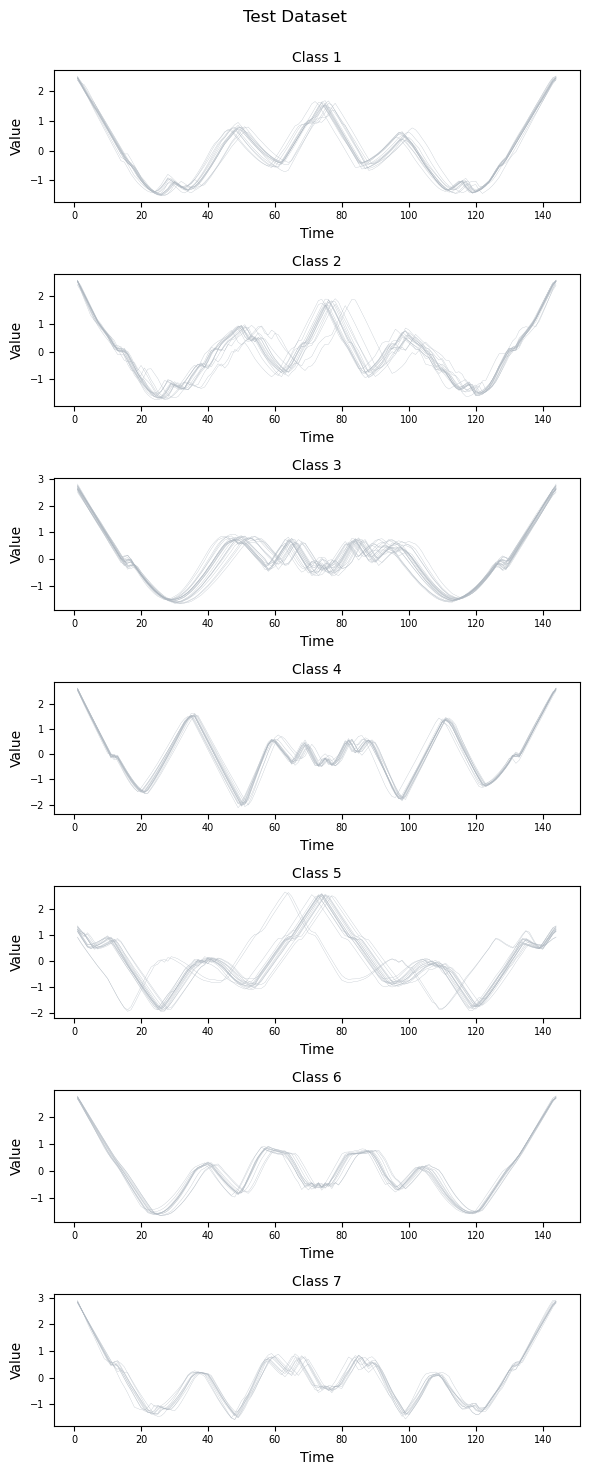

In [16]:
fig, axs = plt.subplots(nrows=test_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 15))
for i, c in enumerate(test_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(test_dataset[test_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.2)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Test Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.show()

Upload the test data to S3, make sure to remove the first column with the class labels.

In [17]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.iloc[:, 1:].to_csv(index=False, header=False),
    bucket=bucket,
    key="Plane_test.csv"
)

In [18]:
test_data

's3://sagemaker-eu-west-1-661670223746/Plane_test.csv'

### 3. Training

Fit the model to the training data.

In [19]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "filters": 32,
        "depth": 6,
        "models": 5,
        "batch-size": 64,
        "lr": 0.001,
        "lr-decay": 0.9,
        "epochs": 50,
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: inception-time-v1-7-2024-01-06-08-03-41-013


2024-01-06 08:03:41 Starting - Starting the training job...
2024-01-06 08:03:55 Starting - Preparing the instances for training......
2024-01-06 08:04:56 Downloading - Downloading input data...
2024-01-06 08:05:25 Downloading - Downloading the training image............
2024-01-06 08:07:41 Training - Training image download completed. Training in progress.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-01-06 08:08:09,338 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-01-06 08:08:09,338 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-06 08:08:09,339 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-06 08:08:09,349 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-01-06 08:08:09,350 sagemaker_pytorch_container.training INFO     Invoking

### 4. Inference

Generate the test set predictions.

In [20]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: inception-time-v1-7-2024-01-06-08-11-26-274


.........

INFO:sagemaker:Creating model with name: inception-time-v1-7-2024-01-06-08-11-26-2024-01-06-08-12-11-684


INFO:sagemaker:Creating transform job with name: inception-time-v1-7-2024-01-06-08-12-12-298


2024-01-06T08:19:09,090 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2024-01-06T08:19:09,092 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2024-01-06T08:19:09,154 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2024-01-06T08:19:09,247 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.2
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7924 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Infer

Load the test set predictions from S3.

In [21]:
predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/Plane_test.csv.out"
)

In [22]:
predictions = pd.read_csv(io.StringIO(predictions), header=None, dtype=float)

In [23]:
predictions.shape

(105, 1)

In [24]:
predictions.head()

,0
0,6.0
1,1.0
2,3.0
3,5.0
4,2.0


In [25]:
predictions.iloc[:, 0].sort_values().unique()

array([1., 2., 3., 4., 5., 6., 7.])

In [26]:
predictions.iloc[:, 0].rename(None).value_counts().sort_index()

1.0    15
2.0    16
3.0    21
4.0    14
5.0    17
6.0    12
7.0    10
Name: count, dtype: int64

Calculate the classification metrics.

In [27]:
metrics = pd.DataFrame(classification_report(y_true=test_dataset.iloc[:, 0], y_pred=predictions.iloc[:, 0], output_dict=True))

In [28]:
metrics

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
support,15.0,16.0,21.0,14.0,17.0,12.0,10.0,1.0,105.0,105.0
